https://www.tensorflow.org/api_docs/python/tf/keras/Model 참조로 cnn 구현해보기

In [0]:
%tensorflow_version 2.x

In [0]:
# 1. 모듈 import
import tensorflow as tf
import os, numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [72]:
# 2. npy 데이터를 불러와서 모델 학습(64 x 64 사이즈의 이미지 약 25000개)
X_train, X_test, y_train, y_test = np.load("/content/drive/My Drive/last.npy", allow_pickle=True)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')  
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}') 

# uint8 -> float32 타입 변환
X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)
y_train = tf.cast(y_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)
X_train.dtype


X_train: (20802, 64, 64, 3), y_train: (20802, 5)
X_test: (5201, 64, 64, 3), y_test: (5201, 5)


tf.float32

In [0]:
# 4. CNN 모델 구성
inputs = tf.keras.Input(shape=(64, 64, 3))
class firstcnn(tf.keras.Model):

  def __init__(self):
    super(firstcnn, self).__init__()
    
    self.conv1 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu)
    self.pool1 = MaxPooling2D(pool_size=(2, 2))
    
    self.conv2 = Conv2D(32, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
    self.pool2 = MaxPooling2D(pool_size=(2, 2))

    self.conv3 = Conv2D(32, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
    self.pool3 = MaxPooling2D(pool_size=(2, 2))
    self.dropout1 = Dropout(0.25)

    self.conv4 = Conv2D(64, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
    self.pool4 = MaxPooling2D(pool_size=(2, 2))
    self.dropout2 = Dropout(0.25)
    self.flat = Flatten()
    
    self.d1 = Dense(256, activation=tf.nn.relu)
    self.dropout3 = Dropout(0.5)
    self.d2 = Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.pool3(x)
    x = self.dropout1(x)
    x = self.conv4(x)
    x = self.pool4(x)
    x = self.dropout2(x)
    x = self.flat(x)
    x = self.d1(x)
    x = self.dropout3(x)
    return self.d2(x)



In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
model = firstcnn()

In [0]:
# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
# 5. 모델 학습
model_dir = "./model"
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
model_path = model_dir + '/test.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(X_train, y_train, epochs=200, batch_size=200, validation_split=0.2, callbacks=[checkpoint, early_stopping])


Train on 16641 samples, validate on 4161 samples
Epoch 1/200
16200/16641 [============================>.] - ETA: 0s - loss: 3.6400 - accuracy: 0.3188
Epoch 00001: val_loss improved from inf to 1.17715, saving model to ./model/test.model
16641/16641 [==============================] - 2s 146us/sample - loss: 3.5760 - accuracy: 0.3223 - val_loss: 1.1772 - val_accuracy: 0.5124
Epoch 2/200
16400/16641 [============================>.] - ETA: 0s - loss: 1.1568 - accuracy: 0.5041
Epoch 00002: val_loss improved from 1.17715 to 0.90663, saving model to ./model/test.model
16641/16641 [==============================] - 2s 98us/sample - loss: 1.1543 - accuracy: 0.5059 - val_loss: 0.9066 - val_accuracy: 0.6626
Epoch 3/200
16000/16641 [===========================>..] - ETA: 0s - loss: 0.9147 - accuracy: 0.6406
Epoch 00003: val_loss improved from 0.90663 to 0.69031, saving model to ./model/test.model
16641/16641 [==============================] - 2s 97us/sample - loss: 0.9161 - accuracy: 0.6402 - val_

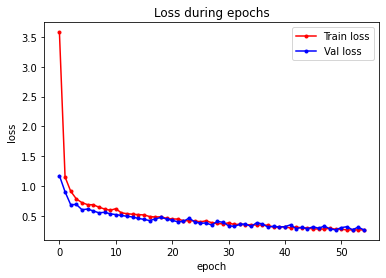

In [78]:
# loss 그래프
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

x = range(len(train_loss))
plt.plot(x, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x, val_loss, marker='.', color='blue', label='Val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss during epochs')
plt.show()

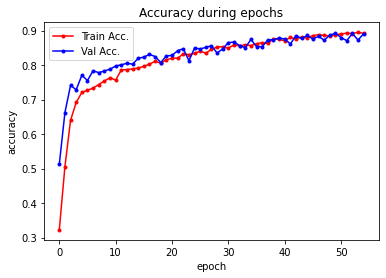

In [79]:
# acc 그래프
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(x, train_acc, marker='.', c='red', label='Train Acc.')
plt.plot(x, val_acc, marker='.', c='blue', label='Val Acc.')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy during epochs')
plt.show()


In [80]:
# Test set으로 모델 평가
score = model.evaluate(X_test, y_test, verbose=0)
print('Training loss:', score[0])
print('Training accuracy: ', score[1])

Training loss: 0.2784612458202844
Training accuracy:  0.8940588


In [81]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(test_true, test_pred)
print(cm)

[[ 955   23   19    7    4]
 [  39  851  149   14    2]
 [  76  153  798    6    1]
 [   8   21    2 1107   13]
 [   3    0    0   11  939]]


In [82]:
# Classification Report
from sklearn.metrics import classification_report
report = classification_report(test_true, test_pred, target_names=os.listdir('/content/drive/My Drive/data_label'))
print(report)

              precision    recall  f1-score   support

       nevus       0.88      0.95      0.91      1008
          df       0.81      0.81      0.81      1055
      eschar       0.82      0.77      0.80      1034
          vl       0.97      0.96      0.96      1151
         mel       0.98      0.99      0.98       953

    accuracy                           0.89      5201
   macro avg       0.89      0.89      0.89      5201
weighted avg       0.89      0.89      0.89      5201



˙ 정확도 약 89% </br>
˙ 쯔쯔가무시 병변 레이블인 eschar의 정확도를 높이는데 1차 목표 </br>
˙ 
˙ 모양새가 서로 비슷해 진단이 어렵다는 vl과 mel의 정확도 주의